In [16]:
import time
import json
import os
import sqlite3

import ioh
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.qmc import discrepancy
from scipy.stats import norm

from modcma.c_maes import ModularCMAES, parameters, options, constants, utils

def colnorm(data):
    return (data - data.min()) / (data.max() - data.min())

sns.set_style("whitegrid")

data_folder = "../../data"
dfile = f"{data_folder}/discr.pkl"
if os.path.exists(dfile):
    discr = pd.read_pickle(dfile)
else:
    names = [x for x in os.listdir(data_folder) if not x.endswith("zip")]
    discrepancy_data  = []
    for name in names:
        if "lambda" in name: continue
        path = os.path.join(data_folder, name)
        functions = [x for x in os.listdir(path) if x.endswith("json")]
        for filename in functions:
            filepath = os.path.join(path, filename)
            
            with open(filepath) as f:
                text = f.read()
                data = json.loads(text.replace(": inf", ": 0"))
            
            for scen in data['scenarios']:
                *x, cache = data['algorithm']['name'].split("-")
                for run_id, run in enumerate(scen['runs'], 1):
                    discrepancy_data.append((
                        data['function_id'], 
                        data['algorithm']['name'],
                        scen['dimension'],
                        run_id, 
                        run['instance'],
                        run['cache_discrepancy'],
                        run['best']['evals'],
                        run['best']['y'],
                        int(cache) if cache.isdigit() else 0
                    ))

    data = pd.DataFrame(discrepancy_data, 
                        columns=["fid", "alg", "dimension",  
                                "run", "instance", "discrepancy", "evals", "y", "cache_size"])
    view = data.query(
        "discrepancy > 0 and not alg.str.contains('mirror') and not alg.str.contains('orthogonal')"
    ).groupby(["dimension", "alg"])['discrepancy'].mean().unstack().T.sort_index()
    view['cache_size'] = view.index.str.rsplit("-").str[-1].astype(int)
    view.index = view.index.str.split("-", n=2).str[-1]
    view.index = view.index.str.replace("-cache", "")
    view['sampler'] = view.index.str.split("-").str[0]
    discr = view.sort_values(["cache_size", "sampler"])[[2, 5, 10, 20, 40]]
    discr = discr.sort_values("alg", key=lambda x:x.str.split("-").str[1].astype(int) + 2 * (x.str[0] == 'H') + 1 * (x.str[0] == 'S') + 3 * (x.str[0] == 'O'))
    discr.index = discr.index.str.replace("GAUSSIAN", "UNIFORM")
    discr.to_pickle(dfile)

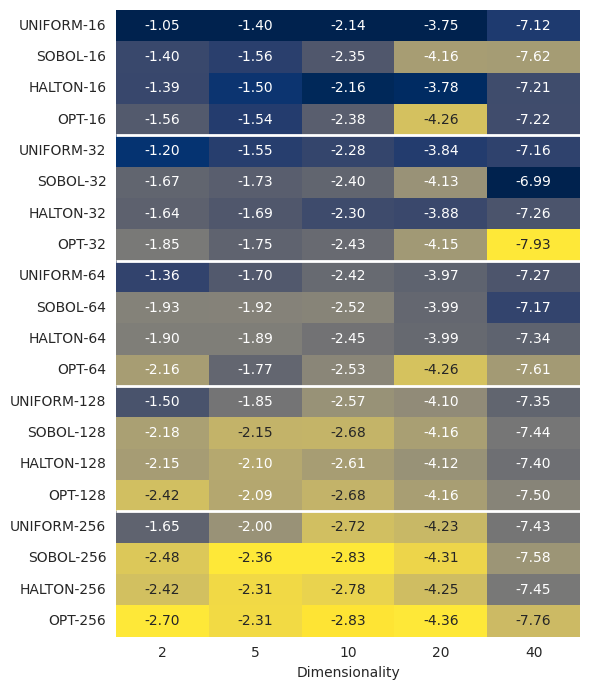

In [17]:

f, ax = plt.subplots(figsize=(6, 7))

sns.heatmap(-colnorm(np.log10(discr)), annot=np.log10(discr), fmt=".2f", cmap="cividis", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("Dimensionality")
# ax.set_title(r"$\log_{10}\ L^{2}$-discrepancy")
ax.hlines([4, 8, 12, 16], *ax.get_xlim(), color="white", linewidth=2)
plt.tight_layout()
plt.savefig(f"{data_folder}/figures/log10_l2_discrepancy.pdf")

In [3]:
view = pd.read_sql(
    r'''
    SELECT run_id, fid, dim, sampler, cache_size, budget, eaf, 
        CAST(SUBSTRING(SUBSTRING(version, INSTR(version, 'lambda')), 7, 2) AS INT) AS lamb
    FROM eaf
    WHERE orthogonal = false AND mirrored = false AND version LIKE '%lambda%'
    ''', sqlite3.connect(f"{data_folder}/eaf/eaf.db", timeout=10)
)
view

,run_id,fid,dim,sampler,cache_size,budget,eaf,lamb
0,1,3,5,OPT,32,2,0.0,16
1,2,3,5,OPT,32,2,0.0,16
2,3,3,5,OPT,32,2,0.0,16
3,4,3,5,OPT,32,2,0.0,16
4,5,3,5,OPT,32,2,0.0,16
...,...,...,...,...,...,...,...,...
2906395,96,1,5,OPT,64,50118,1.0,15
2906396,97,1,5,OPT,64,50118,1.0,15
2906397,98,1,5,OPT,64,50118,1.0,15
2906398,99,1,5,OPT,64,50118,1.0,15


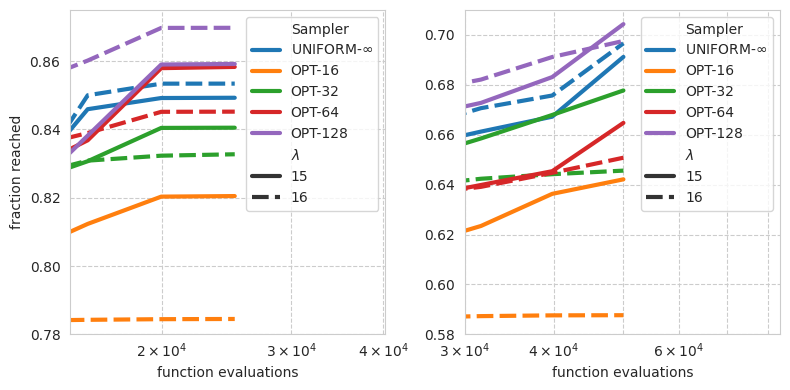

In [4]:
f, axes = plt.subplots(1, 2, figsize=(8, 4))
for dim, ax in zip((2, 5), axes.ravel()):
    default_cma = view.query(f"sampler == 'GAUSSIAN' and dim == {dim} and cache_size == 0")
    pdata  = view.query(f"sampler == 'OPT' and dim == {dim} and cache_size < 250").sort_values(["cache_size"])
    
    pdata = pd.concat([pdata, default_cma])
    pdata.sampler = pdata.sampler.str.replace('GAUSSIAN', 'UNIFORM')
    sns.lineplot(
        pdata,
        x="budget",
        y="eaf",
        hue="cache_size",
        style="lamb",
        errorbar=None,
        palette='tab10',
        lw=3,
        ax=ax,
        # size="sampler",
        # size=2 + 1 * (pdata.cache_size == 0),
        sizes=(2, 3)
    )
    ax.set_xscale("log")
    # ax.set_title(f"{dim}D")
    ax.set_xlabel("function evaluations")
    ax.set_ylabel("fraction reached")
    
    l = ax.get_legend()
    t = l.get_texts()
    t[0].set_text("Sampler")
    t[1].set_text(r"UNIFORM-$\infty$")
    for i in range(2, len(t) - 3):
        t[i].set_text("OPT-" + t[i].get_text())
        
    t[-3].set_text(r"$\lambda$")
    
    if dim == 2:
        ax.set_ylim(.78, .875)
        ax.set_xlim(15_000)
    if dim == 5:
        ax.set_ylim(.58, .71)
        ax.set_xlim(30_000)
        ax.set_ylabel(None)
    
    ax.grid(True, which="both",ls="--")
plt.tight_layout()
plt.savefig(f"{data_folder}/figures/eaf_lambda.pdf")
    

In [5]:
view = pd.read_sql(
    r'''
    SELECT run_id, fid, dim, sampler, cache_size, budget, eaf
    FROM eaf
    WHERE orthogonal = false AND mirrored = false and version NOT LIKE '%lambda%'
    ''', sqlite3.connect(f"{data_folder}/eaf/eaf.db", timeout=10))

view 

,run_id,fid,dim,sampler,cache_size,budget,eaf
0,1,7,20,SOBOL,64,2,0.000000
1,2,7,20,SOBOL,64,2,0.000000
2,3,7,20,SOBOL,64,2,0.000000
3,4,7,20,SOBOL,64,2,0.000000
4,5,7,20,SOBOL,64,2,0.000000
...,...,...,...,...,...,...,...
13113795,96,23,5,OPT,64,50118,0.277213
13113796,97,23,5,OPT,64,50118,0.190354
13113797,98,23,5,OPT,64,50118,0.245902
13113798,99,23,5,OPT,64,50118,0.228458


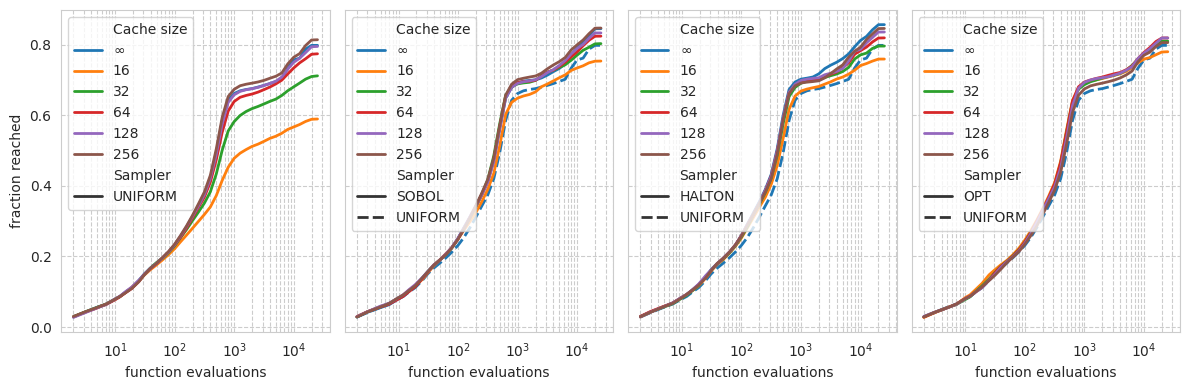

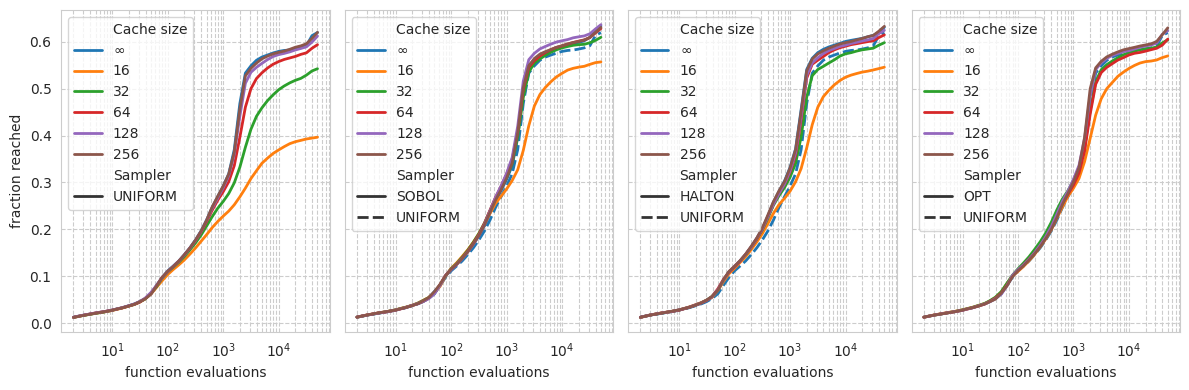

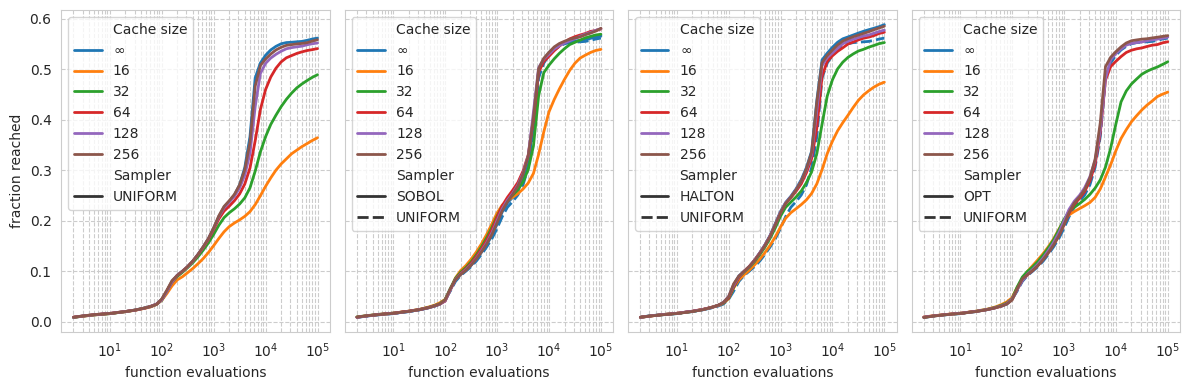

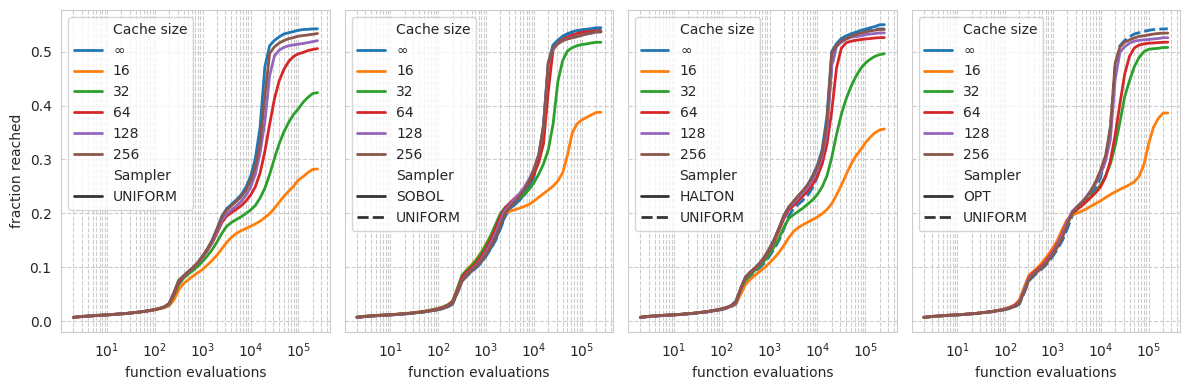

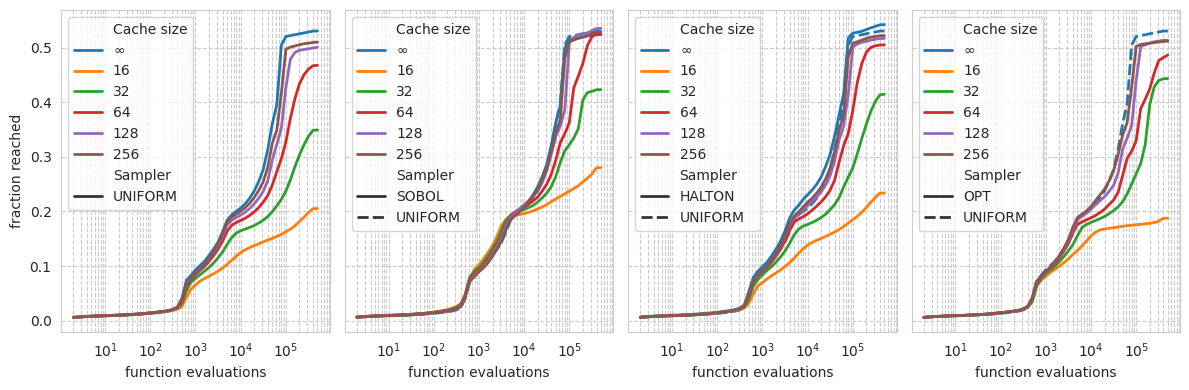

In [11]:
def get_auc(pdata, dim):
    mdata = pdata.groupby("budget")['eaf'].mean()
    max_budget = 10_000 * dim
    mdata[max_budget] = mdata.values[-1]
    mdata = mdata[mdata.index <= max_budget]
    return np.trapz(mdata.values, mdata.index) / max_budget

auc = []
for dim in (2, 5, 10, 20, 40):
    f, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
    default_cma = view.query(f"sampler == 'GAUSSIAN' and dim == {dim} and cache_size == 0")
    for sampler, ax in zip(("GAUSSIAN", "SOBOL", "HALTON", "OPT"), axes.ravel()):
        pdata  = view.query(f"sampler == '{sampler}' and dim == {dim}").sort_values(["cache_size"])
        for cache_size, auc_data  in pdata.groupby("cache_size"):
            auc.append((dim, f"{sampler.replace('GAUSSIAN', 'UNIFORM')}-{cache_size}", get_auc(auc_data, dim)))

        pdata = pd.concat([pdata, default_cma])
        pdata.sampler = pdata.sampler.str.replace('GAUSSIAN', 'UNIFORM')
        sns.lineplot(
            pdata,
            x="budget",
            y="eaf",
            hue="cache_size",
            style="sampler",
            errorbar=None,
            palette='tab10',
            lw=2,
            ax=ax
        )
        l = ax.get_legend()
        t = l.get_texts()
        t[0].set_text("Cache size")
        t[1].set_text(r"$\infty$")
        if sampler != "GAUSSIAN":
            t[-3].set_text("Sampler")
        else:
            t[-2].set_text("Sampler")
            
        
        ax.set_xscale("log")
        # ax.set_title(sampler)
        ax.set_xlabel("function evaluations")
        ax.set_ylabel("fraction reached")
        ax.grid(True, which="both", ls="--")
    # f.suptitle(f"Dimensionality {dim}")
    plt.tight_layout()
    plt.savefig(f"{data_folder}/figures/eaf_d{dim}.pdf")

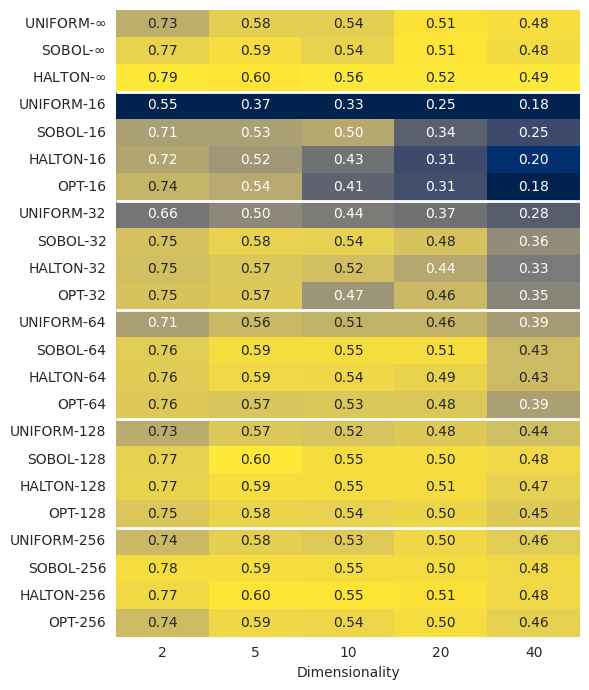

In [7]:
auc_data = pd.DataFrame(auc, columns=['dim', 'sampler', 'auc']).pivot(index="sampler", columns="dim", values="auc")
auc_data = auc_data.sort_values("sampler", key=lambda x:x.str.split("-").str[1].astype(int) + 2 * (x.str[0] == 'H') + 1 * (x.str[0] == 'S') + 3 * (x.str[0] == 'O'))

f, ax = plt.subplots(figsize=(6, 7))
sns.heatmap(colnorm(auc_data),  annot=auc_data, fmt=".2f", cmap="cividis", cbar=False)

ax.set_ylabel("")
ax.set_yticklabels([l._text.replace("0", r"$\infty$") for l in ax.get_yticklabels()])
ax.set_xlabel("Dimensionality")
ax.hlines([3, 7, 11, 15, 19], *ax.get_xlim(), color="white", linewidth=2)
plt.tight_layout()
plt.savefig(f"{data_folder}/figures/eaf_auc_per_dim.pdf")


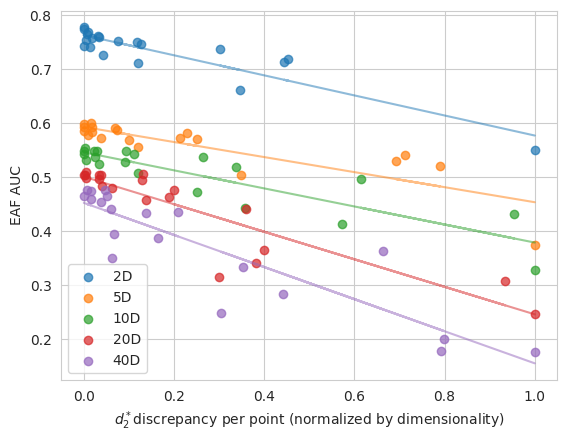

In [8]:
for dim in (2, 5, 10, 20, 40):
    discrn = discr[dim].values / np.repeat([16, 32, 64, 128, 256], 4)

    x, y = colnorm(discrn).ravel(), auc_data[dim].values[3:]
    
    plt.scatter(x, y, label=f"{dim}D", alpha=.7)
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), alpha=.5)
    
    plt.xlabel(r"$d_2^*$discrepancy per point (normalized by dimensionality)")
    plt.ylabel("EAF AUC")
    # plt.grid()
    plt.legend()
    plt.savefig(f"{data_folder}/figures/eaf_auc_vs_l2_discrepancy.pdf")

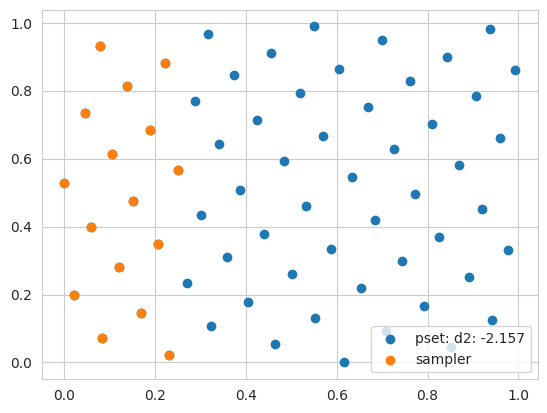

In [9]:
pset = np.loadtxt("../../data/pointsets/OptFib_2_64.txt")[1:]
d2 = np.log10(discrepancy(pset, method="L2-star"))
plt.scatter(*zip(*pset), label=f"pset: d2: {d2:.3f}")
from modcma.c_maes import sampling
sampler = sampling.CachedSampler(pset, True)

cached_sample = norm.cdf(np.vstack([sampler() for _ in range(16)]))
plt.scatter(*zip(*cached_sample), label="sampler")
plt.legend()

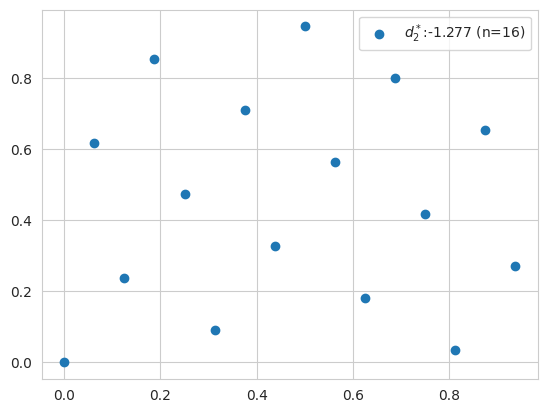

In [10]:
def fibonacci_2d(n):
    return np.array([(i/n,((1+5**0.5)*i/2)%1) for i in range(n)])

n = 16
fibset = fibonacci_2d(n)
d2 = np.log10(discrepancy(fibset, method="L2-star"))
plt.scatter(*zip(fibset.T), label=r"$d_2^*$" + f":{d2:.3f} (n={n})")
plt.legend();